In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime

In [2]:
TICKER = 'AAPL'  # change to any ticker
START = '2015-01-01'
END = datetime.date.today().strftime('%Y-%m-%d')
SEQUENCE_LENGTH = 60
TEST_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 25
MODEL_WEIGHTS_PATH = 'model_weights.h5'

In [3]:
def compute_RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=period, min_periods=period).mean()
    ma_down = down.rolling(window=period, min_periods=period).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [4]:
df = yf.download(TICKER, start=START, end=END, progress=False, auto_adjust=False)

if df.empty:
    raise SystemExit(f'No data fetched for {TICKER} between {START} and {END}')


In [5]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['RSI14'] = compute_RSI(df['Close'], 14)


df = df.dropna().copy()

In [6]:
feature_cols = ['Close', 'MA20', 'MA50', 'RSI14']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])


X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled)):
    X.append(scaled[i-SEQUENCE_LENGTH:i])
    y.append(scaled[i, 0])  # predicting scaled Close

X, y = np.array(X), np.array(y)

In [7]:
# Train-test split
split = int((1 - TEST_RATIO) * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\varin\anaconda3\envs\pydata-book\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.load_weights(MODEL_WEIGHTS_PATH)


In [10]:
model.load_weights(MODEL_WEIGHTS_PATH)

In [11]:
preds_scaled = model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [12]:
placeholder = np.zeros((len(preds_scaled), len(feature_cols)))
placeholder[:, 0] = preds_scaled[:, 0]
inv_preds = scaler.inverse_transform(placeholder)[:, 0]

In [13]:
placeholder_true = np.zeros((len(y_test), len(feature_cols)))
placeholder_true[:, 0] = y_test
inv_true = scaler.inverse_transform(placeholder_true)[:, 0]

In [14]:
rmse = np.sqrt(mean_squared_error(inv_true, inv_preds))
print(f'RMSE on test set: {rmse:.4f}')

RMSE on test set: 15.6867


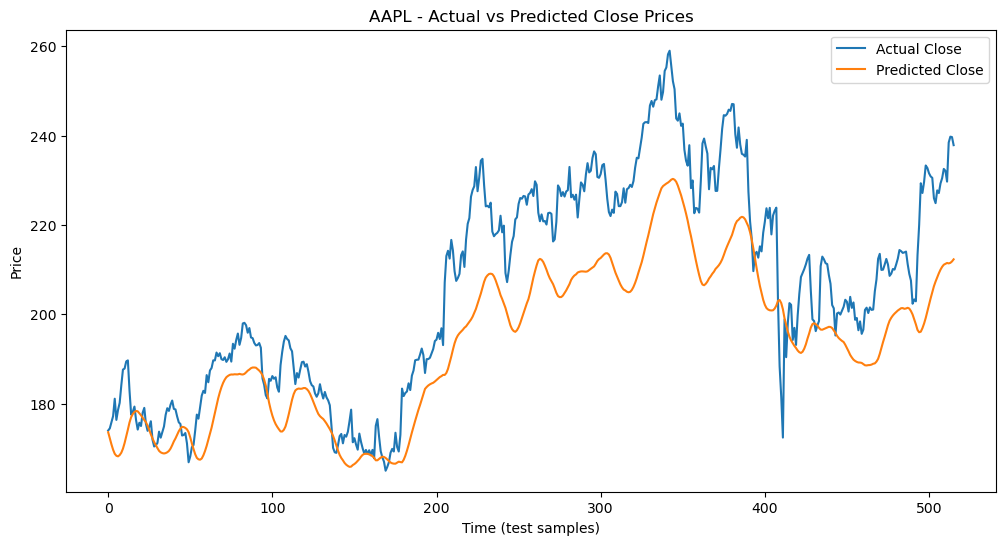

In [15]:
plt.figure(figsize=(12,6))
plt.plot(inv_true, label='Actual Close')
plt.plot(inv_preds, label='Predicted Close')
plt.legend()
plt.title(f'{TICKER} - Actual vs Predicted Close Prices')
plt.xlabel('Time (test samples)')
plt.ylabel('Price')
plt.show()

In [16]:
model.save('lstm_full_model.keras')


In [17]:
results = pd.DataFrame({'Actual': inv_true, 'Predicted': inv_preds})
results.to_csv('predictions.csv', index=False)

In [18]:
app_code = """
import streamlit as st
import pandas as pd
import yfinance as yf
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

st.title('Stock Price Prediction (LSTM)')
model = load_model('lstm_full_model')

TICKER = st.text_input('Ticker', 'AAPL')
if st.button('Predict'):
    df = yf.download(TICKER, start='2015-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'), progress=False)
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Simplified RSI calculation for streamlit app
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=14).mean()
    ma_down = down.rolling(window=14).mean()
    rs = ma_up / ma_down
    df['RSI14'] = 100 - (100 / (1 + rs))

    df = df.dropna()
    feature_cols = ['Close','MA20','MA50','RSI14']
    scaler = MinMaxScaler()
    # Note: Using fit_transform here in the app is for simplicity. 
    # In a production system, you'd save and load the scaler from the training phase.
    scaled = scaler.fit_transform(df[feature_cols]) 
    
    X = []
    SEQUENCE_LENGTH = 60
    # Use only the last part of the data needed for prediction
    last_sequence = scaled[-SEQUENCE_LENGTH:]
    X.append(last_sequence)
    X = np.array(X)

    preds = model.predict(X.reshape(1, SEQUENCE_LENGTH, len(feature_cols)))
    
    placeholder = np.zeros((1, len(feature_cols)))
    placeholder[0,0] = preds[0,0]
    pred_price = scaler.inverse_transform(placeholder)[0,0]
    
    st.write(f'Predicted next day close price for {TICKER}: ${pred_price:.2f}')
"""

with open('app.py', 'w') as f:
    f.write(app_code)

In [19]:
reqs = '''
yfinance
pandas
numpy
matplotlib
scikit-learn
tensorflow
streamlit
'''
with open('requirements.txt', 'w') as f:
    f.write(reqs)

print('Notebook preparation complete. Files created: model_weights.h5 (after training), lstm_full_model/, predictions.csv, app.py, requirements.txt')


Notebook preparation complete. Files created: model_weights.h5 (after training), lstm_full_model/, predictions.csv, app.py, requirements.txt
